In [48]:
import numpy as np
import pandas as pd
import overpy
import geopandas as gpd
import ee
from geetools import batch
import requests
from shapely.geometry import Polygon, box, Point
import os
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt


## OpenStreetMap API

In [49]:
api = overpy.Overpass()

# Fetch all wastewater treatment plants within California's boundary
query = f"""
    area[admin_level=4]["name"="California"]->.searchArea;
    (
      way["man_made"="wastewater_plant"](area.searchArea);
    );
    (._;>;);
    out body;
    """

result = api.query(query)

# Store results in desired format
plants = {}

for way in result.ways:
    # Use the name of the plant or its ID if the name is not available
    plant_name = way.tags.get("name", f"Plant_{way.id}")

    # Extract nodes lat and lon without id
    nodes_coords = [(node.lon, node.lat) for node in way.nodes]

    # get rid of "Decimal"  in the coordinates
    nodes_coords = [tuple(map(float, i)) for i in nodes_coords]
    
    plants[plant_name] = nodes_coords


In [50]:
geoms = [Polygon(plants[key]) for key in plants]
df = gpd.GeoDataFrame({'WWTP_name': list(plants.keys()), 'geometry': geoms}, crs="EPSG:4326")
df

,WWTP_name,geometry
0,Plant_24298754,"POLYGON ((-121.80940 37.69305, -121.80582 37.6..."
1,Plant_24396910,"POLYGON ((-121.78360 36.80423, -121.78363 36.8..."
2,EBMUD Wastewater Treatment Plant,"POLYGON ((-122.29310 37.82285, -122.29238 37.8..."
3,Hyperion Wastewater Treatment Plant,"POLYGON ((-118.42914 33.91957, -118.43162 33.9..."
4,San José–Santa Clara Regional Wastewater Facility,"POLYGON ((-121.95539 37.43062, -121.95452 37.4..."
...,...,...
3101,Plant_1188491467,"POLYGON ((-121.52373 38.56623, -121.52238 38.5..."
3102,Plant_1201733978,"POLYGON ((-118.94698 37.64148, -118.94744 37.6..."
3103,Plant_1205552620,"POLYGON ((-121.96382 38.68125, -121.96450 38.6..."
3104,Plant_1213883271,"POLYGON ((-120.46290 38.12344, -120.46263 38.1..."


In [51]:
df["centroid"] = df.to_crs('+proj=cea').centroid.to_crs(epsg=4326)

In [52]:
df

,WWTP_name,geometry,centroid
0,Plant_24298754,"POLYGON ((-121.80940 37.69305, -121.80582 37.6...",POINT (-121.80762 37.69120)
1,Plant_24396910,"POLYGON ((-121.78360 36.80423, -121.78363 36.8...",POINT (-121.78025 36.79990)
2,EBMUD Wastewater Treatment Plant,"POLYGON ((-122.29310 37.82285, -122.29238 37.8...",POINT (-122.29525 37.82512)
3,Hyperion Wastewater Treatment Plant,"POLYGON ((-118.42914 33.91957, -118.43162 33.9...",POINT (-118.43006 33.92574)
4,San José–Santa Clara Regional Wastewater Facility,"POLYGON ((-121.95539 37.43062, -121.95452 37.4...",POINT (-121.94663 37.43156)
...,...,...,...
3101,Plant_1188491467,"POLYGON ((-121.52373 38.56623, -121.52238 38.5...",POINT (-121.52255 38.56391)
3102,Plant_1201733978,"POLYGON ((-118.94698 37.64148, -118.94744 37.6...",POINT (-118.94450 37.63989)
3103,Plant_1205552620,"POLYGON ((-121.96382 38.68125, -121.96450 38.6...",POINT (-121.96297 38.67961)
3104,Plant_1213883271,"POLYGON ((-120.46290 38.12344, -120.46263 38.1...",POINT (-120.46110 38.12511)


## Concat lists

In [53]:
df_yz_yes = pd.read_excel('YZ_Yes.xlsx')
df_yz_yes_maybe = pd.read_excel('YZ_Yes_and_Maybe.xlsx')

df_dy_yes = pd.read_excel('DY_Yes.xlsx')
df_dy_yes_maybe = pd.read_excel('DY_Yes_and_Maybe.xlsx')

df_ss_yes_maybe = pd.read_excel('SS_Maybe.xlsx')

df_pooja_yes = pd.read_excel('Pooja_Yes.xlsx')
df_pooja_yes_maybe = pd.read_excel('Pooja_Yes_and_Maybe.xlsx')

df_original_missing_yes = pd.read_excel('Original_Missing_Yes.xlsx')
df_original_missing_yes_maybe = pd.read_excel('Original_Missing_Yes_and_Maybe.xlsx')

In [54]:
# concat all yes and all yes_and_maybe
df_yes = pd.concat([df_yz_yes, df_dy_yes, df_pooja_yes, df_original_missing_yes])
df_yes.reset_index(drop=True, inplace=True)
df_yes_maybe = pd.concat([df_yz_yes_maybe, df_dy_yes_maybe, df_ss_yes_maybe, df_pooja_yes_maybe, df_original_missing_yes_maybe])
df_yes_maybe = df_yes_maybe.iloc[:,:1]
df_yes_maybe.reset_index(drop=True, inplace=True)

print(f"Number of plants in yes: {len(df_yes)}")
print(f"Number of plants in yes_maybe: {len(df_yes_maybe)}")

Number of plants in yes: 119
Number of plants in yes_maybe: 306


In [55]:
gdf_yes = df.loc[df['WWTP_name'].isin(df_yes['filename'])]
gdf_yes_maybe = df.loc[df['WWTP_name'].isin(df_yes_maybe['filename'])]

print(f"Number of plants in yes: {len(gdf_yes)}")
print(f"Number of plants in yes_maybe: {len(gdf_yes_maybe)}")

Number of plants in yes: 115
Number of plants in yes_maybe: 299


In [65]:
# save to csv
gdf_yes.to_csv('gdf_Yes.csv')
gdf_yes_maybe.to_csv('gdf_Yes_and_Maybe.csv')

## Plotting

In [56]:
# visualize the centroid of the plants in the map
import folium
import branca
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

# Create a map
m = folium.Map(location=[37, -120], zoom_start=6)

# Add points to the map
mc = MarkerCluster()
for idx, row in gdf_yes.iterrows():
    mc.add_child(folium.Marker(location=[row['centroid'].y, row['centroid'].x]))
m.add_child(mc)

# Display the map
m


In [57]:
# save as interactive html
m.save('CA_Yes.html')

In [58]:
# Create a map
m = folium.Map(location=[37, -120], zoom_start=6)

# Add points to the map
mc = MarkerCluster()
for idx, row in gdf_yes_maybe.iterrows():
    mc.add_child(folium.Marker(location=[row['centroid'].y, row['centroid'].x]))
m.add_child(mc)

# Display the map
m


In [59]:
m.save('CA_Yes_Maybe.html')

## Static plots

In [60]:
gdf_yes_centroid = gdf_yes.loc[:, ['WWTP_name', 'centroid']]
# change centroid to geometry point
gdf_yes_centroid['geometry'] = gdf_yes_centroid['centroid'].apply(lambda x: Point(x))
gdf_yes_centroid.drop(columns=['centroid'], inplace=True)
gdf_yes_centroid.to_crs(epsg=4326, inplace=True)

gdf_yes_and_maybe_centroid = gdf_yes_maybe.loc[:, ['WWTP_name', 'centroid']]
# change centroid to geometry point
gdf_yes_and_maybe_centroid['geometry'] = gdf_yes_and_maybe_centroid['centroid'].apply(lambda x: Point(x))
gdf_yes_and_maybe_centroid.drop(columns=['centroid'], inplace=True)
gdf_yes_and_maybe_centroid.to_crs(epsg=4326, inplace=True)

In [61]:
df_christine = pd.read_excel('CA_VerifiedSolar_VerifiedLocation.xlsx')
df_christine = df_christine.loc[:, ['FacilityName', 'Lat, Long']]
df_christine['lat'] = df_christine['Lat, Long'].apply(lambda x: float(x.split(',')[0]))
df_christine['lon'] = df_christine['Lat, Long'].apply(lambda x: float(x.split(',')[1]))
df_christine.drop(columns=['Lat, Long'], inplace=True)

# convert to geodataframe
gdf_christine = gpd.GeoDataFrame(df_christine, geometry=gpd.points_from_xy(df_christine.lon, df_christine.lat))
gdf_christine.crs = 'epsg:4326'
gdf_christine.head()

,FacilityName,lat,lon,geometry
0,Alvarado WWTF,37.592371,-122.091334,POINT (-122.09133 37.59237)
1,AUBURN WWTF,38.888344,-121.109503,POINT (-121.10950 38.88834)
2,Bakersfield 2,35.325050,-118.967661,POINT (-118.96766 35.32505)
3,Bakersfield 3,35.325808,-118.973105,POINT (-118.97310 35.32581)
4,Chowchilla WWTP,37.104374,-120.260346,POINT (-120.26035 37.10437)


/home/codespace/.python/current/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


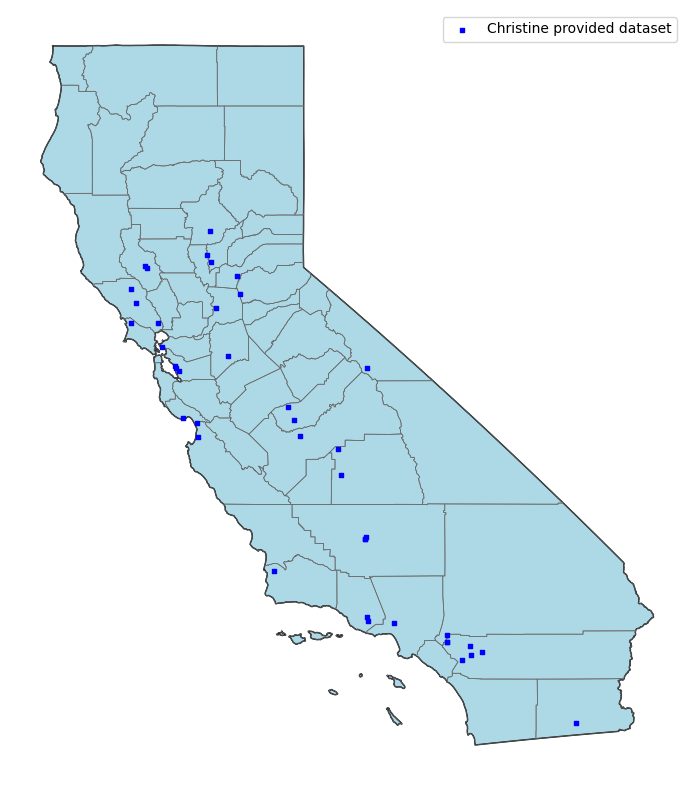

In [62]:
import geopandas as gpd
import matplotlib.pyplot as plt

# URLs to shapefiles
url_state = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_5m.zip'
url_counties = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_5m.zip'
url_places = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_place_5m.zip'

# Load data
states = gpd.read_file(url_state)
counties = gpd.read_file(url_counties)

# Filter for California and its counties and places
california = states[states['STUSPS'] == 'CA']
ca_counties = counties[counties['STATEFP'] == '06']
california.to_crs(epsg=4326, inplace=True)
ca_counties.to_crs(epsg=4326, inplace=True)

# Plot Christine's data
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_christine.plot(ax=ax, marker='s', color='blue', markersize=8, label='Christine provided dataset')

# Set title
plt.axis('off')
plt.legend()
plt.show()


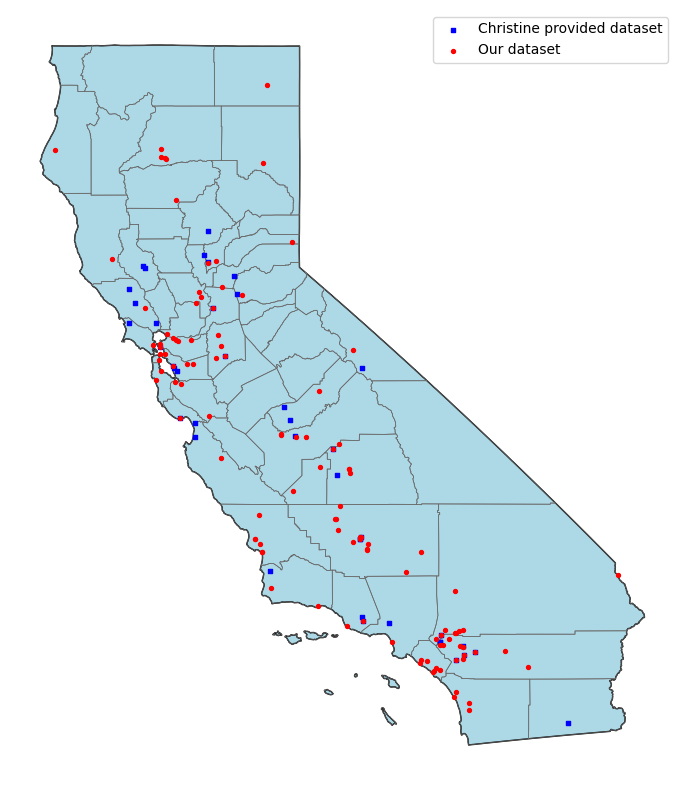

In [63]:
# Plot Christine's data and our data
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_christine.plot(ax=ax, marker='s', color='blue', markersize=8, label='Christine provided dataset')
gdf_yes_centroid.plot(ax=ax, marker='o', color='red', markersize=8, label='Our dataset')
ax.legend()

# Set title
plt.axis('off')
plt.legend()
plt.show()

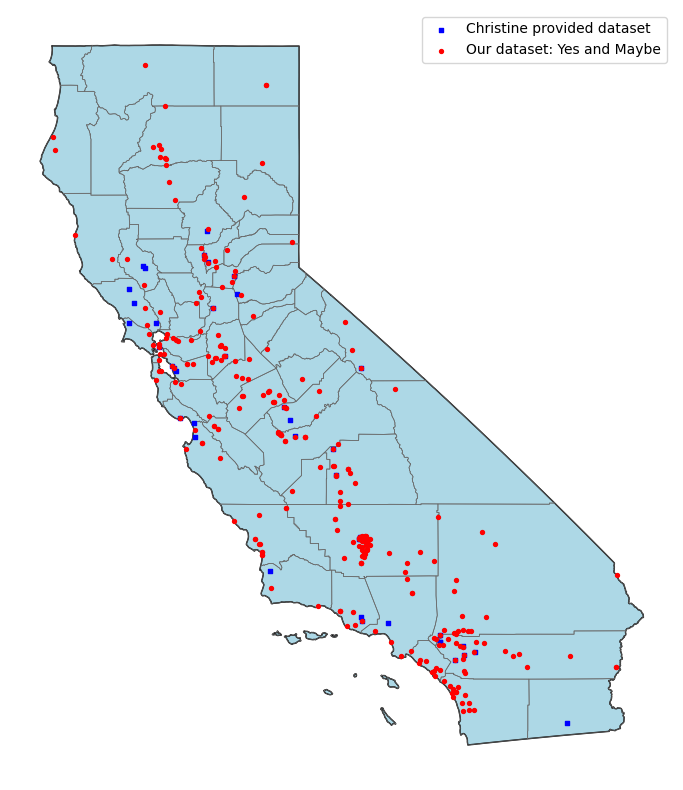

In [70]:
# Plot Christine's data and our data
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
gdf_christine.plot(ax=ax, marker='s', color='blue', markersize=8, label='Christine provided dataset')
gdf_yes_and_maybe_centroid.plot(ax=ax, marker='o', color='red', markersize=8, label='Our dataset: Yes and Maybe')
ax.legend()

# Set title
plt.axis('off')
plt.legend()
plt.show()

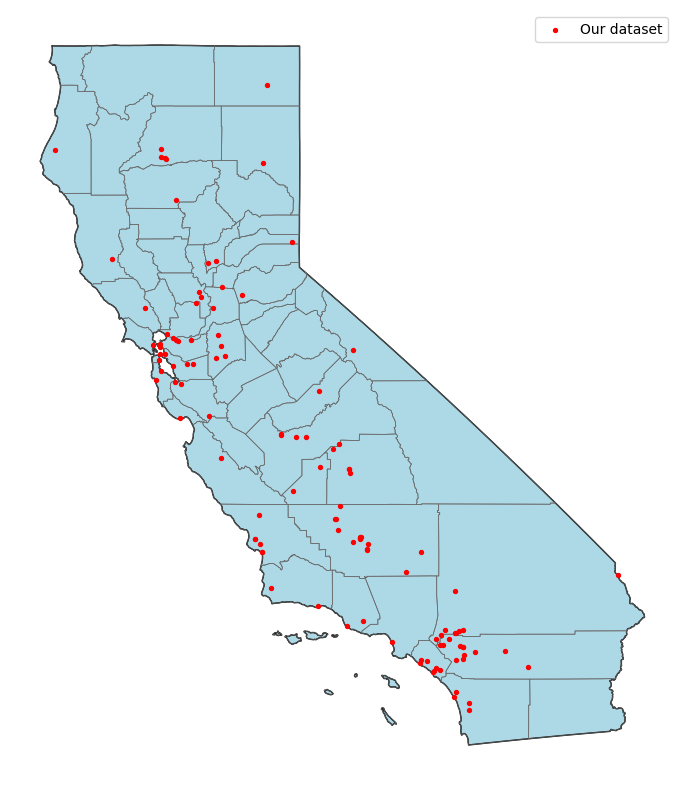

In [64]:
# Plot our data
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
# gdf_christine.plot(ax=ax, marker='s', color='blue', markersize=8, label='Christine provided dataset')
gdf_yes_centroid.plot(ax=ax, marker='o', color='red', markersize=8, label='Our dataset')
ax.legend()

# Set title
plt.axis('off')
plt.legend()
plt.show()

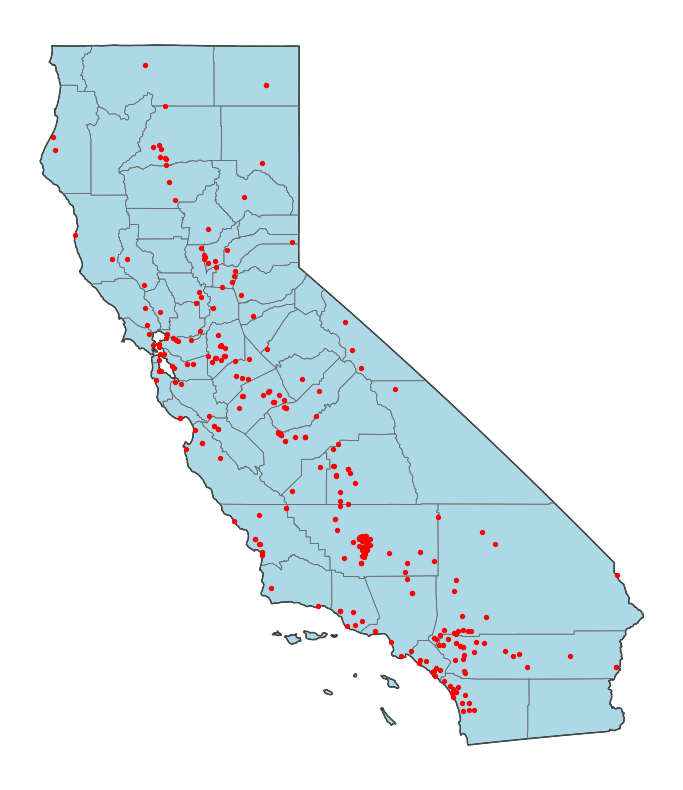

In [69]:
# Plot our data
fig, ax = plt.subplots(figsize=(10, 10))
california.plot(ax=ax, color='lightblue', edgecolor='black')
ca_counties.plot(ax=ax, facecolor='none', edgecolor='dimgrey', linewidth=0.5)
# gdf_christine.plot(ax=ax, marker='s', color='blue', markersize=8, label='Christine provided dataset')
gdf_yes_and_maybe_centroid.plot(ax=ax, marker='o', color='red', markersize=8, label='Our dataset')
# ax.legend()

# Set title
plt.axis('off')
# plt.legend()
plt.show()